## PyTorch exercises

## Implementing a deep convolutional neural network using PyTorch

### The multilayer CNN architecture

In [2]:
from IPython.display import Image
%matplotlib inline
#Image(filename='figures/14_12.png', width=800)

### Loading and preprocessing the data

In [3]:
import torch
import numpy as np
import torchvision 
from torchvision import transforms 
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=True, 
                                           transform=transform, 
                                           download=True)

from torch.utils.data import Subset
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000)) 
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=False, 
                                           transform=transform, 
                                           download=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████| 9912422/9912422 [00:01<00:00, 8313295.03it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████| 28881/28881 [00:00<00:00, 223509.55it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████| 1648877/1648877 [00:01<00:00, 839998.27it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 1150741.70it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
from torch.utils.data import DataLoader


batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

### Implementing a CNN using the torch.nn module

#### Configuring CNN layers in PyTorch

 * **Conv2d:** `torch.nn.Conv2d`
   * `out_channels`
   * `kernel_size`
   * `stride`
   * `padding`
   
   
 * **MaxPool2d:** `torch.nn.MaxPool2d`
   * `kernel_size`
   * `stride`
   * `padding`
   
   
 * **Dropout** `torch.nn.Dropout`
   * `p`

### Constructing a CNN in PyTorch

In [5]:
import torch.nn as nn
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))   
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))      

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

In [6]:
model.add_module('flatten', nn.Flatten()) 

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 3136])

In [7]:
model.add_module('fc1', nn.Linear(3136, 1024)) 
model.add_module('relu3', nn.ReLU()) 
model.add_module('dropout', nn.Dropout(p=0.5)) 

model.add_module('fc2', nn.Linear(1024, 10)) 

In [14]:
#device = torch.device("mps")
device = torch.device("cpu")

model = model.to(device) 

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9984 val_accuracy: 0.9903
Epoch 2 accuracy: 0.9986 val_accuracy: 0.9906
Epoch 3 accuracy: 0.9981 val_accuracy: 0.9896
Epoch 4 accuracy: 0.9990 val_accuracy: 0.9920
Epoch 5 accuracy: 0.9990 val_accuracy: 0.9907
Epoch 6 accuracy: 0.9979 val_accuracy: 0.9876
Epoch 7 accuracy: 0.9988 val_accuracy: 0.9914
Epoch 8 accuracy: 0.9987 val_accuracy: 0.9905
Epoch 9 accuracy: 0.9988 val_accuracy: 0.9907
Epoch 10 accuracy: 0.9985 val_accuracy: 0.9899
Epoch 11 accuracy: 0.9985 val_accuracy: 0.9905
Epoch 12 accuracy: 0.9991 val_accuracy: 0.9910
Epoch 13 accuracy: 0.9991 val_accuracy: 0.9888
Epoch 14 accuracy: 0.9987 val_accuracy: 0.9898
Epoch 15 accuracy: 0.9990 val_accuracy: 0.9911
Epoch 16 accuracy: 0.9993 val_accuracy: 0.9913
Epoch 17 accuracy: 0.9985 val_accuracy: 0.9885
Epoch 18 accuracy: 0.9988 val_accuracy: 0.9907
Epoch 19 accuracy: 0.9990 val_accuracy: 0.9901
Epoch 20 accuracy: 0.9988 val_accuracy: 0.9918


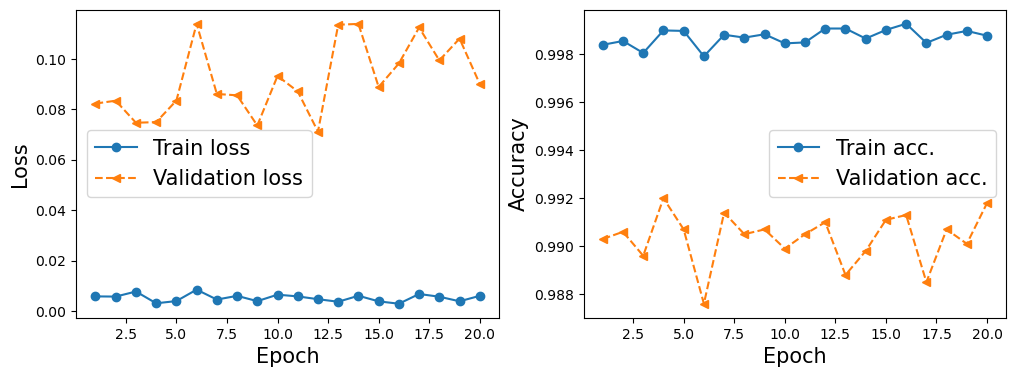

In [17]:
import matplotlib.pyplot as plt


x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

In [18]:
torch.mps.synchronize()
model_cpu = model.cpu()
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}') 

Test accuracy: 0.9940


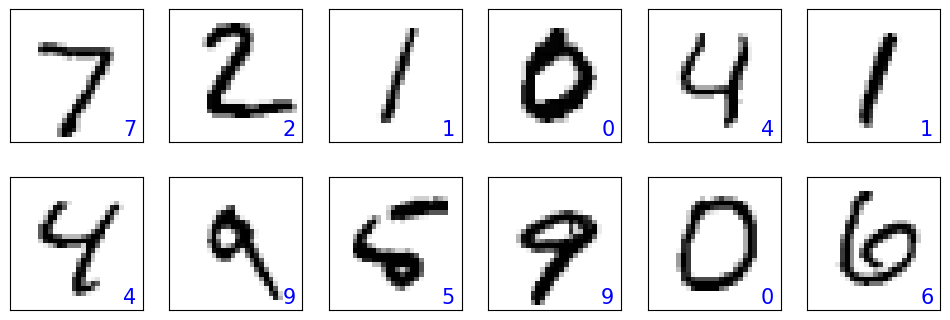

In [19]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
    
#plt.savefig('figures/14_14.png')
plt.show()

In [20]:
import os

if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/mnist-cnn.ph'
torch.save(model, path)
 

### Tensors

1. Make a tensor of size (2, 17)
2. Make a torch.FloatTensor of size (3, 1)
3. Make a torch.LongTensor of size (5, 2, 1)
  - fill the entire tensor with 7s
4. Make a torch.ByteTensor of size (5,)
  - fill the middle 3 indices with ones such that it records [0, 1, 1, 1, 0]
5. Perform a matrix multiplication of two tensors of size (2, 4) and (4, 2). Then do it in-place.
6. Do element-wise multiplication of two randomly filled $(n_1,n_2,n_3)$ tensors. Then store the result in an Numpy array.

### Forward-prop/backward-prop
1. Create a Tensor that `requires_grad` of size (5, 5).
2. Sum the values in the Tensor.
3. Multiply the tensor by 2 and assign the result to a new python variable (i.e. `x = result`)
4. Sum the variable's elements and assign to a new python variable
5. Print the gradients of all the variables
6. Now perform a backward pass on the last variable (NOTE: for each new python variable that you define, call `.retain_grad()`)
7. Print all gradients again

### Deep-forward NNs
1. Use dl_lab2. In Exercise 12 there, you had to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. Reimplement the manual code in PyTorch.
2. Compare test accuracy using different optimizers: SGD, Adam, Momentum.

# Tensors

In [105]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn

In [23]:
tensor_2_17 = torch.Tensor(2, 17)

In [24]:
float_tensor_3_1 = torch.FloatTensor(3, 1)

In [25]:
long_tensor_5_2_1 = torch.LongTensor(5, 2, 1).fill_(7)

In [35]:
byte_tensor_5 = torch.ByteTensor([0, 0, 0, 0, 0])
byte_tensor_5[1:4] = 1

In [43]:
result = torch.mm(torch.randn(2, 4), torch.randn(4, 2))
result

tensor([[-0.3828, -4.2485],
        [ 3.3821,  0.8297]])

In [52]:
tensor_5 = torch.randn(2, 4)
tensor_5.mm(torch.randn(4, 2))

tensor([[ 1.0381, -0.0617],
        [-0.7227,  1.6102]])

In [53]:
print(byte_tensor_5)

tensor([0, 1, 1, 1, 0], dtype=torch.uint8)


In [62]:
torch.randn(2, 3, 4) * torch.randn(2, 3, 4)

tensor([[[ 4.8187e-01, -1.4044e+00, -1.2258e+00,  7.3669e-02],
         [ 1.3051e-01,  7.6669e-02, -2.5845e-01,  2.3458e-01],
         [-6.2734e-01,  4.3834e-03, -2.1273e+00, -1.5788e+00]],

        [[-9.3419e-01, -2.1041e-01, -7.0326e-02,  6.4596e-01],
         [ 1.0663e-02,  5.7046e-03,  5.7611e-01,  4.5344e-01],
         [ 8.9301e-02, -5.3951e-02, -8.7809e-02, -2.0179e-03]]])

# Forward-prop/backward-prop

In [83]:
tensor_grad = torch.randn(5, 5, requires_grad=True)

In [84]:
sum_tensor = tensor_grad.sum()

In [85]:
x = tensor_grad * 2

In [86]:
sum_x = x.sum()

In [90]:
print(tensor_grad.grad)
print(x.grad)

None
None


/var/folders/lc/txlwmxx91wz8fm_fqvv9b4v80000gn/T/ipykernel_41235/213343381.py:2: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(x.grad)


In [91]:
x.retain_grad()
sum_x.backward()

In [92]:
print(tensor_grad.grad)
print(x.grad)

tensor([[2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.]])
tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])


# Deep-forward NNs

In [106]:
input_size = 12288
hidden_size = 64
output_size = 1
L = 3   

In [107]:
X_train = torch.randn(100, input_size)
Y_train = torch.randn(100, output_size)
X_test = torch.randn(20, input_size)
Y_test = torch.randn(20, output_size)

In [108]:
class LLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, L):
        super(LLayerNN, self).__init__()
        self.L = L
        self.linears = nn.ModuleList([nn.Linear(input_size, hidden_size) if i == 0 else nn.Linear(hidden_size, hidden_size) for i in range(L-1)])
        self.linears.append(nn.Linear(hidden_size, output_size))
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        for i in range(self.L-1):
            x = self.relu(self.linears[i](x))
        x = self.sigmoid(self.linears[self.L-1](x))
        return x

In [109]:
model = LLayerNN(input_size, hidden_size, output_size, L)
print(model)

LLayerNN(
  (linears): ModuleList(
    (0): Linear(in_features=12288, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [110]:
def train_and_evaluate(model, optimizer, criterion, X_train, Y_train, X_test, Y_test, epochs=100):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, Y_train)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, Y_test)
    return test_loss.item()

In [111]:
criterion = nn.MSELoss()

In [112]:
model_sgd = LLayerNN(input_size, hidden_size, output_size, L)
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)
test_loss_sgd = train_and_evaluate(model_sgd, optimizer_sgd, criterion, X_train, Y_train, X_test, Y_test)

In [113]:
model_adam = LLayerNN(input_size, hidden_size, output_size, L)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.01)
test_loss_adam = train_and_evaluate(model_adam, optimizer_adam, criterion, X_train, Y_train, X_test, Y_test)

In [114]:
model_momentum = LLayerNN(input_size, hidden_size, output_size, L)
optimizer_momentum = optim.SGD(model_momentum.parameters(), lr=0.01, momentum=0.9)
test_loss_momentum = train_and_evaluate(model_momentum, optimizer_momentum, criterion, X_train, Y_train, X_test, Y_test)

In [115]:
print(f'Test Loss (SGD): {test_loss_sgd}')
print(f'Test Loss (Adam): {test_loss_adam}')
print(f'Test Loss (Momentum): {test_loss_momentum}')

Test Loss (SGD): 1.9066438674926758
Test Loss (Adam): 2.0893959999084473
Test Loss (Momentum): 1.7758255004882812
